# Harmonic oscillator

This notebook is intended to compute and visualise the misfit curve for observations of a harmonic oscillator. These observations are made at random intervals, and the misfit is the regular root-mean-squared misfit.

**copyright**: Andreas Fichtner (andreas.fichtner@erdw.ethz.ch), December 2020

**license**: BSD 3-Clause ("BSD New" or "BSD Simplified")

## 1. Python packages and other setup

We start with the import of some Python packages and with some embellishments of the figures.

In [1]:
import nsh
import numpy as np
import matplotlib.cm as cm
from scipy.stats import ncx2
import matplotlib.pyplot as plt

# Embellish figures
plt.rcParams["font.family"] = "Times"
plt.rcParams.update({'font.size': 50})
plt.rcParams['xtick.major.pad']='12'
plt.rcParams['ytick.major.pad']='12'

## 2. Input

In [3]:
# Read input parameters.
params=nsh.read_parameters('parameters.yml')

# Amplitude of harmonic oscillator.
amp=params['amp']
# Estimated model.
m_est=params['m_init']
# Number of observations.
N=params['N_obs']
# Set a random seed for reproducibility
random_seed=params['random_seed']

## 3. Forward model and observations

For convenience, we define the forward model as a function G, so it can easily be modified.

In [4]:
def G(t,amp):
    return amp*np.sin(t)

## 4. Plot forward model and observation points

We choose a true circular frequency and a number of observations. The observation times are then computed randomly.

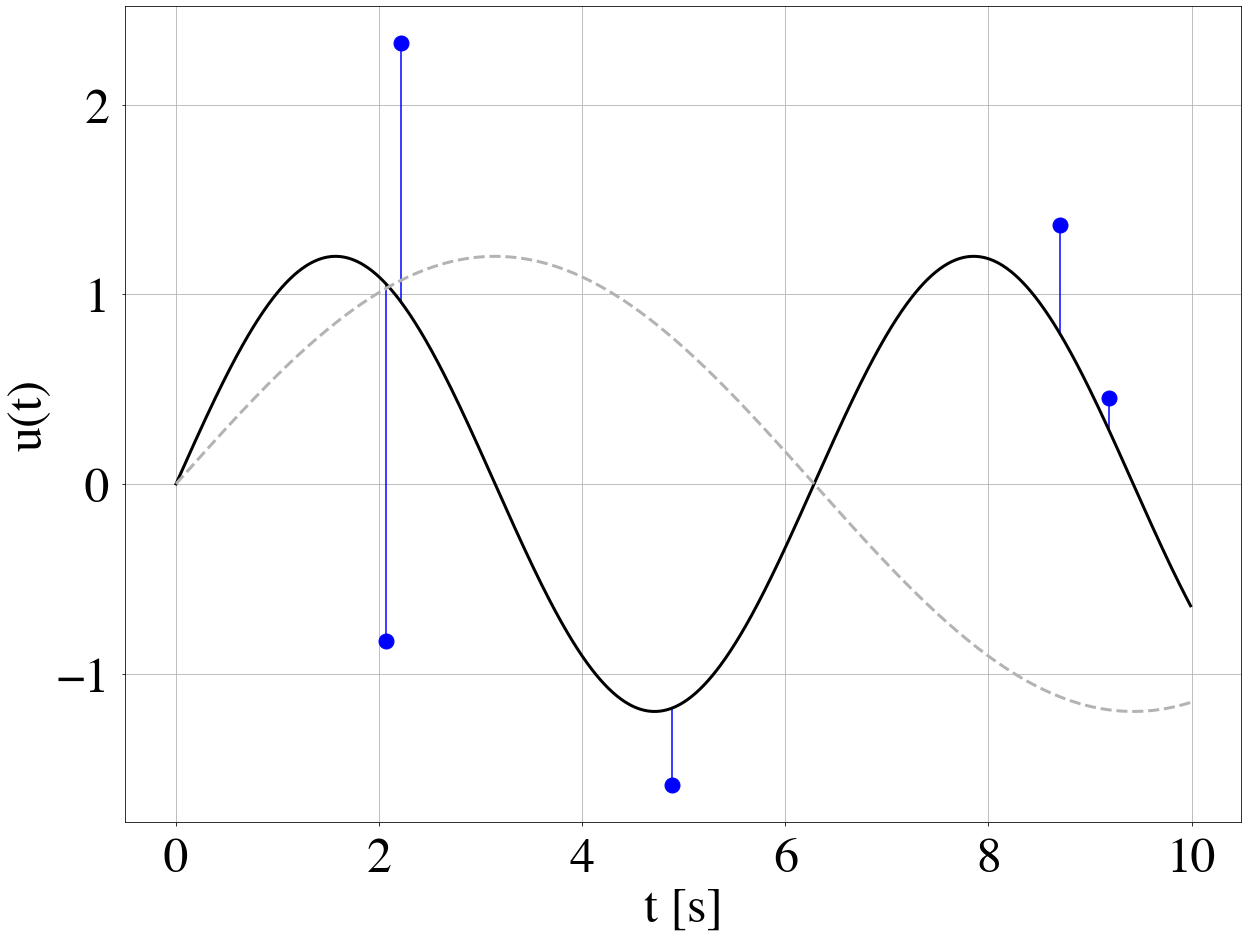

In [5]:
np.random.seed(random_seed)

# Time axis and observation times.
t=np.arange(0.0,10.0,0.01)
t_obs=10.0*np.random.rand(N)

# True observations contaminated by Gaussian noise.
d_obs_perfect=G(t_obs,amp)
d_obs=d_obs_perfect+np.random.randn(N)

# Plot oscillation and its observations.
plt.subplots(1, figsize=(20,15))
for i in range(N): 
    plt.plot([t_obs[i],t_obs[i]],[G(t_obs[i],amp),d_obs[i]],'b')
    plt.plot(t_obs[i],d_obs[i],'bo',MarkerSize=15)
plt.xlabel('t [s]')
plt.ylabel('u(t)')
plt.plot(t,G(t,amp),'k',linewidth=3)
plt.plot(t,G(m_est*t,amp),'--',color=[0.7,0.7,0.7],linewidth=3)
plt.grid()
plt.savefig('Output/oscillator.png',format='png',bbox_inches='tight')
plt.show()

## 5. Plot misfit curve

The actual observations of the oscillation amplitude are computed by adding random numbers to the perfect observations. Then we define a coordinate line of model parameter values (circular frequencies). Based on them, we can compute and visualise the root-mean-square misfit.

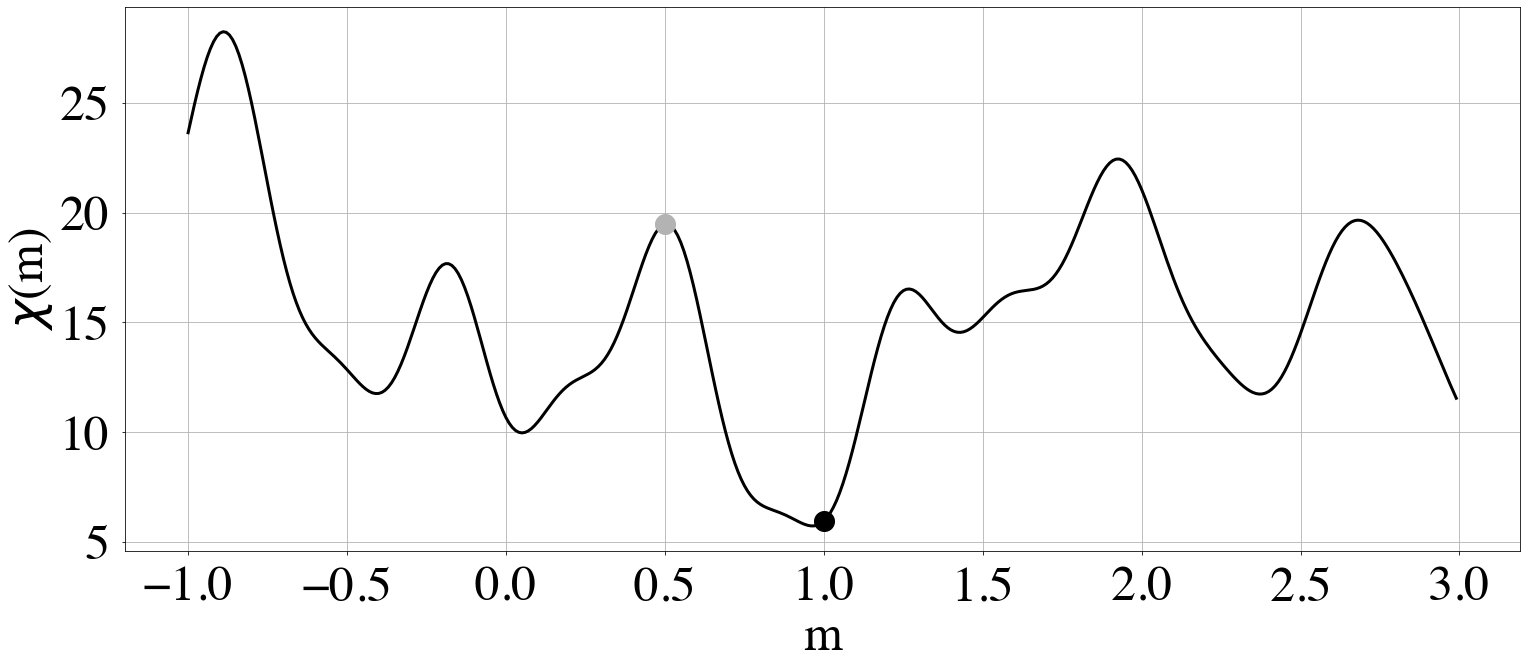

In [6]:
# Model vector.
m=np.arange(-1.0,3.0,0.01)

# Misfit
chi=0.0
chi_true=0.0
chi_est=0.0
for i in range(N): 
    chi+=(d_obs[i]-G(m*t_obs[i],amp))**2.0
    chi_est+=(d_obs[i]-G(m_est*t_obs[i],amp))**2.0
    chi_true+=(d_obs[i]-G(t_obs[i],amp))**2.0
    
# Plot.
plt.subplots(1, figsize=(25,10))
plt.plot(m,chi,'k',linewidth=3)
plt.plot(m_est,chi_est,'o',color=[0.7,0.7,0.7],markersize=20)
plt.plot(1.0,chi_true,'ko',markersize=20)
plt.xlabel('m')
plt.ylabel('$\chi$(m)')
plt.grid()
plt.savefig('Output/misfit.png',format='png',bbox_inches='tight')
plt.show()

## 6. Probability density of the misfit

Due to the random nature of the observational errors, the misfit is described by a probability density. In this particular case, due to choosing Gaussian errors and a least-squares misfit, this probability density is a non-central chi-squared distribution.

estimated misfit: 19.481384
estimated non-centrality: 14.481384


/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:563: RuntimeWarning: divide by zero encountered in log
  res += np.log(ive(df2, xs*ns) / 2.0)


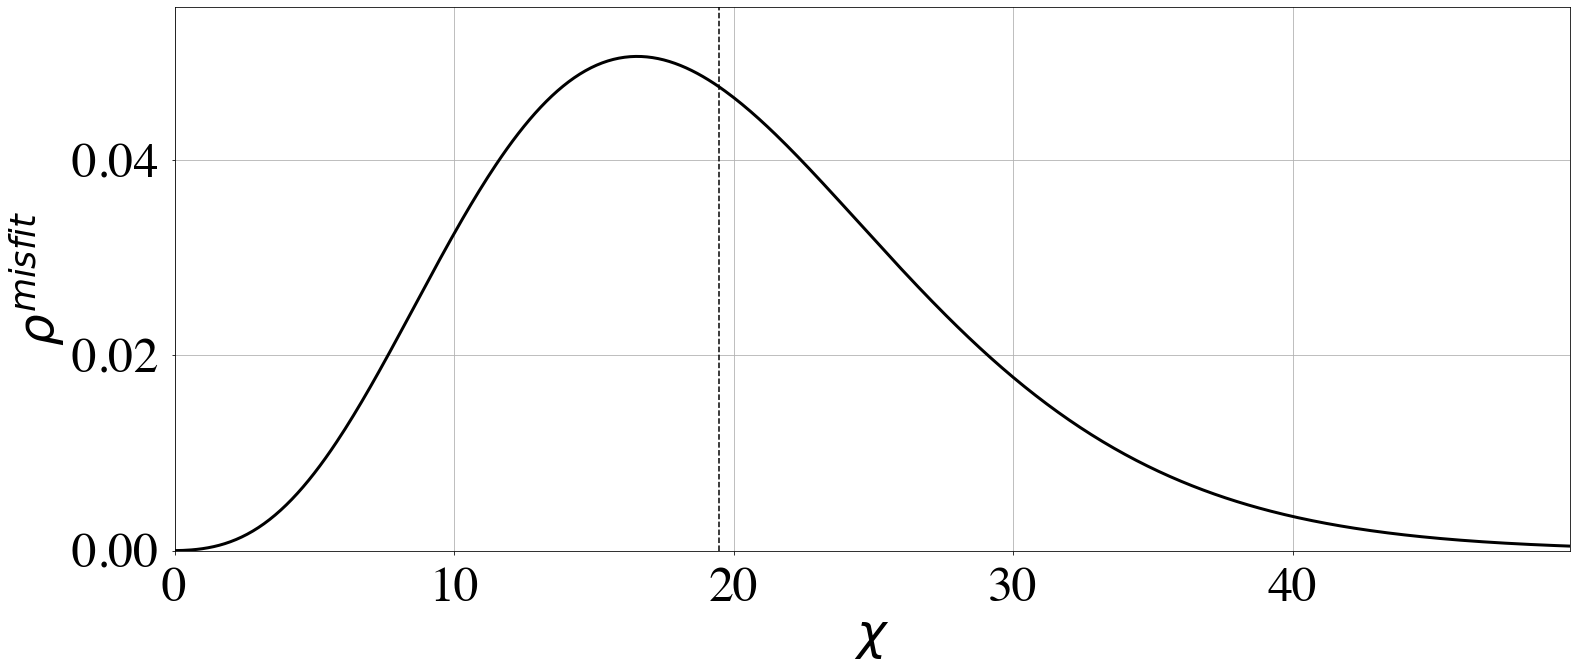

In [9]:
# Compute estimated misfit.
d_est=G(m_est*t_obs,amp)
chi_est=np.sum((d_obs-d_est)**2)
print('estimated misfit: %f' % chi_est)

# Compute noncentral chi-square distribution.
nc=np.maximum(chi_est-np.float(N),0.0)
print('estimated non-centrality: %f' % nc)
x=np.arange(0.0,50.0,0.1)
p=ncx2.pdf(x,N,nc)

# Plot distribution.
plt.subplots(1, figsize=(25,10))
plt.plot(x,p,'k',linewidth=3.0)
plt.plot([chi_est,chi_est],[0.0,1.1*np.max(p)],'k--')
plt.xlim([0.0,x[-1]])
plt.ylim([0.0,1.1*np.max(p)])
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\rho^{misfit}$')
plt.grid()
plt.savefig('Output/misfit_distribution.png',format='png',bbox_inches='tight')
plt.show()

## 7. Probability density of tolerances

From the probability density of the misfit we can derive a probability density of the misfit tolerances. Here this is given by a shifted version of the non-central chi-squared distribution.

probability of lower misfit: 0.544862


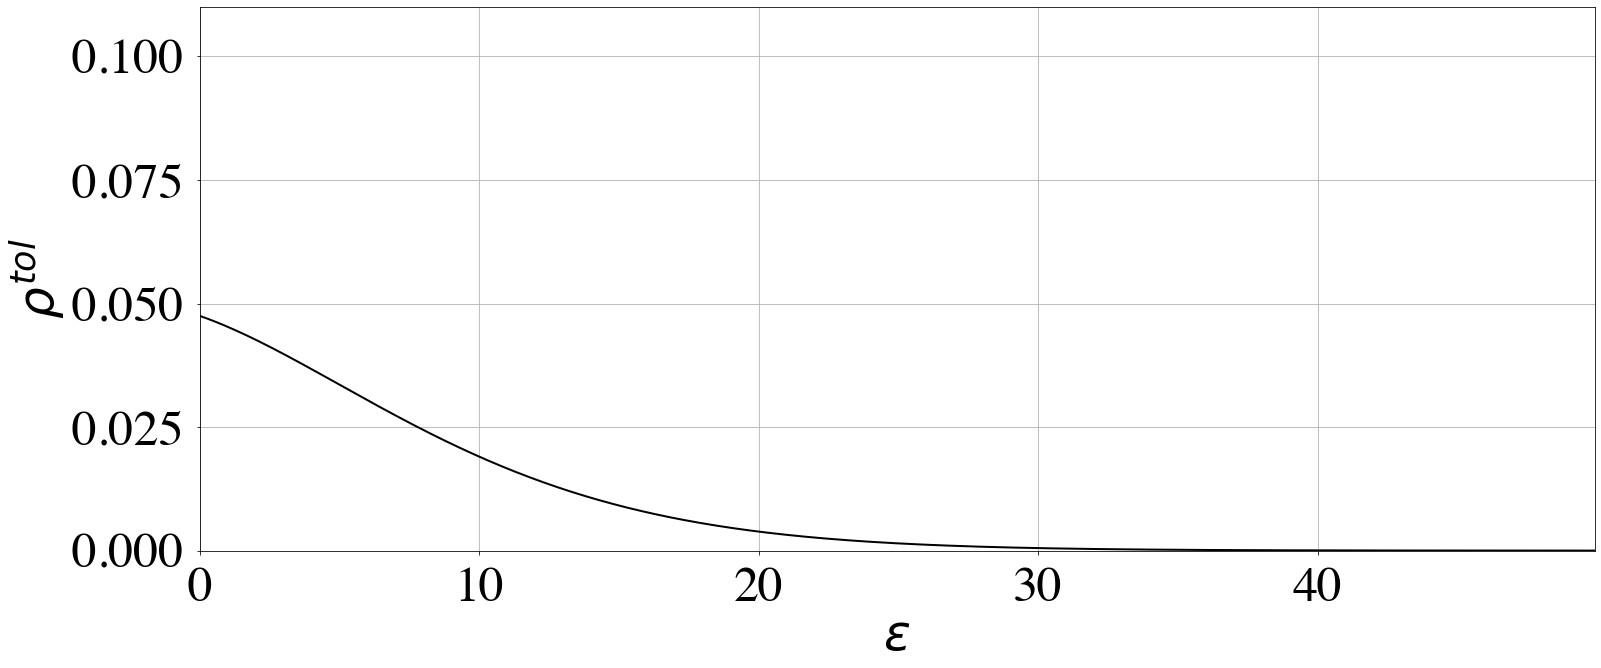

In [12]:
# Compute integral for chi<chi_est. Gives normalisation constant of delta contribution.
idx=(np.abs(x-chi_est)).argmin()
dx=x[1]-x[0]
k=np.sum(p[:idx])*dx
print('probability of lower misfit: %f' % k)

# Shifted chi-squared distribution.
eps=np.arange(0.0,50.0,0.1)
p_eps=ncx2.pdf(eps+chi_est,N,nc)

# Plot.
plt.subplots(1, figsize=(25,10))
plt.plot(eps,p_eps,'k',linewidth=2.0)
plt.xlim([0.0,eps[-1]])
plt.ylim([0.0,0.11])
plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'$\rho^{tol}$')
plt.grid()
plt.savefig('Output/tolerance_distribution.png',format='png',bbox_inches='tight')
plt.show()

## 8. Joint probability density in tolerance-model space

In [ ]:
# Model vector.
m=np.arange(-1.0,3.0,0.01)
# Tolerance vector.
eps=np.arange(0.0,30.0,0.5)

# Joint distribution.
M,E=np.meshgrid(m,eps)
rho=np.zeros(np.shape(E))

# March through misfit values to obtain distributions of chi.
for i in range(len(chi)):
    rho[:,i]=np.log10(ncx2.pdf(eps+chi[i],N,nc)*np.exp(-chi[i]))
    
# Plot.
plt.subplots(1, figsize=(20,15))
plt.pcolor(M,E,rho,cmap=cm.gray)
plt.colorbar()
plt.contour(M,E,rho,colors='grey',linewidths=3,linestyles='dashed')
#plt.title('log10 of joint distribution')
plt.xlabel('m')
plt.ylabel('$\epsilon$')
plt.savefig('Output/joint_distribution.png',format='png',bbox_inches='tight')
plt.show()